In [3]:
!nvidia-smi

Sat May 15 06:32:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)
plt.rc('figure', figsize=(13, 4))

2.4.1


In [5]:
# https://github.com/42io/dataset/tree/master/google_speech_commands
# zero one two three four five six seven eight nine #unk# #pub#
DATASET_FILE = '1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu'

In [6]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

Downloading...
From: https://drive.google.com/uc?id=1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
To: /content/1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
2.59GB [00:37, 69.2MB/s]


In [7]:
md5 = !md5sum "$DATASET_FILE"
assert '54821a74684e7bbb9b3acd853960d9cd' == md5[0].split()[0]

In [8]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1095480, 637)


In [9]:
def create_ds(t):
  x = 'x_' + t
  y = 'y_' + t
  d = tf.data.Dataset.from_tensor_slices((dset[x], dset[y]))
  d = d.map(lambda x, y: [tf.cast(x, tf.float32), y])
  d = d.map(lambda x, y: [x, tf.cast(y, tf.int8)])
  d = d.map(lambda x, y: [tf.reshape(x, (49, 13))[1:-1], y])
  return d

In [10]:
train_dataset = create_ds('train')
test_dataset  = create_ds('test')
valid_dataset = create_ds('valid')
train_dataset.cardinality().numpy()

1095480

In [11]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [13]:
apply_batch   = lambda d: d.batch(128)
train_dataset = train_dataset.shuffle(train_dataset.cardinality())
train_dataset = apply_batch(train_dataset)
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset  = apply_batch(test_dataset)
valid_dataset = apply_batch(valid_dataset)

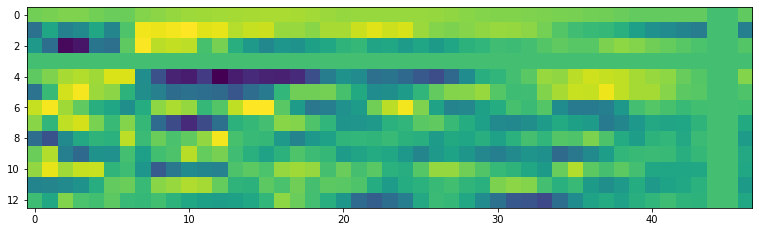

In [27]:
plt.imshow(list(train_dataset.take(1))[0][0][0].numpy().T)

In [14]:
def first_ensemble(x_in):
  x = keras.layers.Conv1D(128, 1, use_bias=False)(x_in)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.SpatialDropout1D(0.1)(x)

  for i in range(4):
    x = keras.layers.SeparableConv1D(x.shape[-1], 2, dilation_rate=2**i,
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)

  x = keras.layers.AveragePooling1D(x.shape[1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1], use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Dense(12)(x)
  x = keras.layers.Softmax()(x)
  return x

In [15]:
def second_ensemble(x_in):
  x = keras.layers.Conv1D(128, 1, use_bias=False)(x_in)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.SpatialDropout1D(0.1)(x)

  for i in range(4)[::-1]:
    x = keras.layers.SeparableConv1D(x.shape[-1], 3, padding="same",
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)
    x = keras.layers.MaxPooling1D(2 if i else x.shape[1], padding="same")(x)

  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1], use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Dense(12)(x)
  x = keras.layers.Softmax()(x)
  return x

In [16]:
def decode(x):
  first, second = [tf.argmax(i, -1) for i in x]
  x = tf.equal(first, second)
  x = tf.where(x, first, 10)
  x = tf.one_hot(x, 12)
  return x

def build_model(inference=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  x_in = keras.Input(shape=(47, 13))
  x = [first_ensemble(x_in), second_ensemble(x_in)]

  return keras.Model(x_in, keras.layers.Lambda(decode)(x) if inference else x)

In [17]:
model = build_model()
model.summary()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 13)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 47, 128)      1664        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 47, 128)      512         conv1d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_6 (ReLU)                  (None, 47, 128)      0           batch_normalization_6[0][0]      
______________________________________________________________________________________________

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=50,
        restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

Epoch 1/100500
8559/8559 - 258s - loss: 0.6568 - softmax_loss: 0.3325 - softmax_1_loss: 0.3243 - softmax_accuracy: 0.8934 - softmax_1_accuracy: 0.8957 - val_loss: 0.1577 - val_softmax_loss: 0.0691 - val_softmax_1_loss: 0.0886 - val_softmax_accuracy: 0.9780 - val_softmax_1_accuracy: 0.9760
Epoch 2/100500
8559/8559 - 226s - loss: 0.3522 - softmax_loss: 0.1777 - softmax_1_loss: 0.1745 - softmax_accuracy: 0.9430 - softmax_1_accuracy: 0.9438 - val_loss: 0.1275 - val_softmax_loss: 0.0546 - val_softmax_1_loss: 0.0728 - val_softmax_accuracy: 0.9822 - val_softmax_1_accuracy: 0.9786
Epoch 3/100500
8559/8559 - 226s - loss: 0.3005 - softmax_loss: 0.1522 - softmax_1_loss: 0.1483 - softmax_accuracy: 0.9512 - softmax_1_accuracy: 0.9524 - val_loss: 0.1046 - val_softmax_loss: 0.0464 - val_softmax_1_loss: 0.0582 - val_softmax_accuracy: 0.9855 - val_softmax_1_accuracy: 0.9822
Epoch 4/100500
8559/8559 - 220s - loss: 0.2709 - softmax_loss: 0.1368 - softmax_1_loss: 0.1341 - softmax_accuracy: 0.9558 - softma

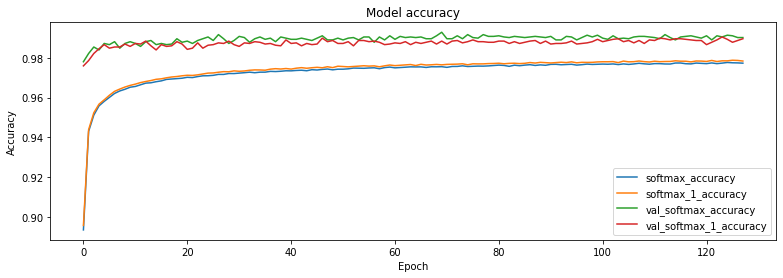

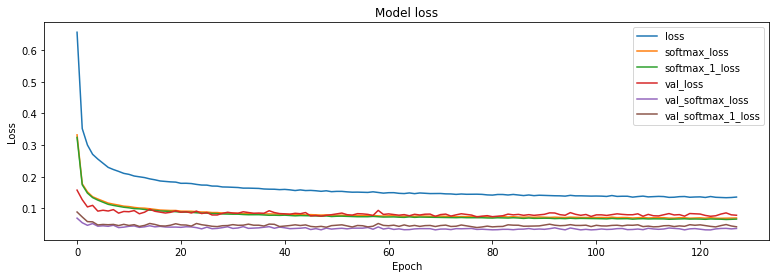

In [19]:
l = [k for k in history.history.keys() if k.endswith('accuracy')]
for k in l:
  plt.plot(history.history[k])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(l, loc='lower right')
plt.show()

l = [k for k in history.history.keys() if k.endswith('loss')]
for k in l:
  plt.plot(history.history[k])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(l, loc='upper right')
plt.show()

In [20]:
results = model.evaluate(train_dataset, verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(test_dataset, verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(valid_dataset, verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.07900462299585342, 0.0404452420771122, 0.03855929523706436, 0.986760139465332, 0.9873964190483093]
test loss, test acc: [0.1129082441329956, 0.052630480378866196, 0.06027777120471001, 0.9819772243499756, 0.9848926663398743]
valid loss, valid acc: [0.07299594581127167, 0.03348136693239212, 0.03951457887887955, 0.9916864633560181, 0.9881235361099243]


In [21]:
def transfer_weights(dest, src):
  for layer in dest.layers:
    if layer.get_weights():
      layer.set_weights(src.get_layer(name=layer.name).get_weights())

In [22]:
ensamble_model = build_model(True)
transfer_weights(ensamble_model, model)

In [23]:
conf_ds = test_dataset.concatenate(valid_dataset)
matrix = tf.math.confusion_matrix(
  list(conf_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()),
  ensamble_model.predict(conf_ds).argmax(axis=-1)).numpy()
for r in matrix:
  l = np.sum(r)
  for i in r:
    print(('%.2f' % (i / l)).replace('0.00', ' .  '), end = ' ')
  print("|", l)

0.98  .    .    .    .    .    .    .    .    .   0.01  .   | 603
 .   0.98  .    .    .    .    .    .    .   0.01 0.02  .   | 575
 .    .   0.98  .    .    .    .    .    .    .   0.02  .   | 564
 .    .    .   0.97  .    .   0.01  .    .    .   0.03  .   | 548
 .    .    .    .   0.97  .    .    .    .    .   0.03  .   | 605
 .    .    .    .    .   0.98  .    .    .    .   0.01  .   | 607
 .    .    .    .    .    .   0.99  .    .    .   0.01  .   | 462
 .    .    .    .    .    .    .   0.99  .    .   0.01  .   | 574
 .    .    .    .    .    .    .    .   1.00  .    .    .   | 547
 .    .    .    .    .    .    .    .    .   0.99 0.01  .   | 596
 .   0.01  .    .    .    .    .    .    .    .   0.98  .   | 730
 .    .    .    .    .    .    .    .    .    .    .   1.00 | 730


In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(ensamble_model)
tflite_model = converter.convert()
with open("dcnn.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzuclyz6w/assets


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [26]:
!md5sum 'dcnn.tflite'
!mv 'dcnn.tflite' '/content/gdrive/My Drive/0-9.edcnn.47.tflite'

aef413dee414573c8f8fe0ecb5ad3c0b  dcnn.tflite
